In [1]:
import os
import IPython.display
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import pickle as pkl
import sys
import time

from PIL import Image, ImageDraw

import re 
import shutil
import logging, sys
import json

import shutil

import numpy.ma as ma

import scipy.ndimage
import scipy.interpolate

from sklearn.model_selection import train_test_split
RANDOM_SEED = 8675309
np.random.seed(RANDOM_SEED)

import logging, sys
logging.basicConfig(stream=sys.stderr, level=logging.INFO) # INFO # WARNING # ERROR


DATASETS_DIR = "..\\datasets\\"
ADE2016_DIR = os.path.join(DATASETS_DIR, "ADE") 



#
CLASS_ID_INVALID = 0
NUM_ORIGINAL_CLASSES = 150

## Transform the ADE2016 directory into a servicible training environment (to be called once!)

In [2]:
def transform_dataset(dataset_dir=ADE2016_DIR):
    ''' Transform the dataset into a servicible training environment '''
    annotations_dir = os.path.join(dataset_dir, "annotations") 
    annotations_train_dir = os.path.join(annotations_dir, "training") 
    annotations_val_dir = os.path.join(annotations_dir, "validation") 
    
    images_dir = os.path.join(dataset_dir, "images")
    images_train_dir = os.path.join(images_dir, "training")
    images_val_dir = os.path.join(images_dir, "validation")
    
    # Assert that the dataset has not been consolidated yet
    assert(os.path.isdir(annotations_train_dir))
    assert(os.path.isdir(annotations_val_dir))
    assert(os.path.isdir(images_train_dir))
    assert(os.path.isdir(images_val_dir))
    
    # Concatenate validation annotations to train annotations
    annotation_train_count = 0
    for annotation_train in os.scandir(annotations_train_dir):
        annotation_train_count += 1
        
    for annotation_val in os.scandir(annotations_val_dir):
        #print(annotation_val.name)
        new_base_name = re.split('\_|\.', annotation_val.name)
        new_base_name[1] = "train"
        new_base_name[2] = str(int(new_base_name[2]) + annotation_train_count).zfill(8)
    
        new_base_name = new_base_name[0] + '_' + new_base_name[1] + '_' + new_base_name[2] + '.' + new_base_name[3]
    
        shutil.copy(annotation_val, os.path.join(annotations_train_dir, new_base_name))
        
    # Concatenate validation images to train images
    image_train_count = 0
    for image_train in os.scandir(images_train_dir):
        image_train_count += 1
        
    for image_val in os.scandir(images_val_dir):
        new_base_name = re.split('\_|\.', image_val.name)
        new_base_name[1] = "train"
        new_base_name[2] = str(int(new_base_name[2]) + image_train_count).zfill(8)
    
        new_base_name = new_base_name[0] + '_' + new_base_name[1] + '_' + new_base_name[2] + '.' + new_base_name[3]
    
        shutil.copy(image_val, os.path.join(images_train_dir, new_base_name))
    
    
    # Move the contents of the training to the parent directory
    for annotation_train in os.listdir(annotations_train_dir):
        shutil.move(os.path.join(annotations_train_dir, annotation_train), annotations_dir)
    
    for image_train in os.listdir(images_train_dir):
        shutil.move(os.path.join(images_train_dir, image_train), images_dir)
    
    
    # Delete extraneous folders
    shutil.rmtree(annotations_train_dir)
    shutil.rmtree(annotations_val_dir)
    shutil.rmtree(images_train_dir)
    shutil.rmtree(images_val_dir)
    
    
    # Rename
    for annotation in os.listdir(annotations_dir):
        new_base_name = re.split('\_|\.', annotation)
        new_base_name[1] = "annotation"
        new_base_name = new_base_name[0] + '_' + new_base_name[1] + '_' + new_base_name[2] + '.' + new_base_name[3]
        os.rename(os.path.join(annotations_dir, annotation), os.path.join(annotations_dir, new_base_name))
    
    for image in os.listdir(images_dir):
        new_base_name = re.split('\_|\.', image)
        new_base_name[1] = "image"
        new_base_name = new_base_name[0] + '_' + new_base_name[1] + '_' + new_base_name[2] + '.' + new_base_name[3]
        os.rename(os.path.join(images_dir, image), os.path.join(images_dir, new_base_name))
    
    
    # Realign index to 0-based index
    i = 1
    for annotation in os.listdir(annotations_dir):
        new_base_name = re.split('\_|\.', annotation)
        old_index = int(new_base_name[2])
        if not old_index == i:
            print("ERROR", old_index, i)
            break
        new_base_name[2] = str(old_index-1).zfill(8)
        new_base_name = new_base_name[0] + '_' + new_base_name[1] + '_' + new_base_name[2] + '.' + new_base_name[3]
        os.rename(os.path.join(annotations_dir, annotation), os.path.join(annotations_dir, new_base_name))
        i += 1
        
    i = 1
    for image in os.listdir(images_dir):
        new_base_name = re.split('\_|\.', image)
        old_index = int(new_base_name[2])
        if not old_index == i:
            print("ERROR", old_index, i)
            break
        new_base_name[2] = str(old_index-1).zfill(8)
        new_base_name = new_base_name[0] + '_' + new_base_name[1] + '_' + new_base_name[2] + '.' + new_base_name[3]
        os.rename(os.path.join(images_dir, image), os.path.join(images_dir, new_base_name))
        i += 1
    
    # Create npy files from the annotation pngs
    for annotation in os.listdir(annotations_dir):
        new_base_name = re.split('\_|\.', annotation)
        new_base_name[1] = "annotation"
        new_base_name = new_base_name[0] + '_' + new_base_name[1] + '_' + new_base_name[2] + '.' + 'npy'
        info = cv2.imread(os.path.join(annotations_dir, annotation))
        npy_matrix = info[:,:,0]
        np.save(os.path.join(annotations_dir, new_base_name), npy_matrix)
    
    # Create labels directory and move npy files to it with a rename from annotation to label
    assert(not os.path.isdir(labels_dir))
    labels_dir = os.path.join(dataset_dir, "labels")
    os.mkdir(labels_dir)
    for annotation in os.listdir(annotations_dir):
        base_name = re.split('\_|\.', annotation)
        if base_name[3] == "npy":
            old_base_name = base_name[0] + "_" + base_name[1] + "_" + base_name[2] + '.' + base_name[3] 
            new_base_name = base_name[0] + "_" + "label" + "_" + base_name[2] + '.' + base_name[3]    
            shutil.move(os.path.join(annotations_dir, old_base_name), os.path.join(labels_dir, new_base_name))

'''
transform_dataset()
'''

'\ntransform_dataset()\n'

## Plot the segmentation data (Data exploration)

..\datasets\ADE\images


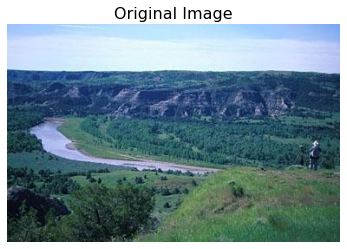

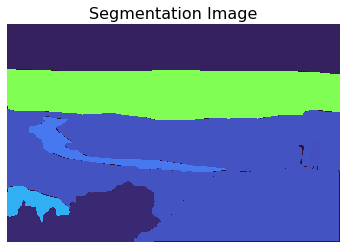

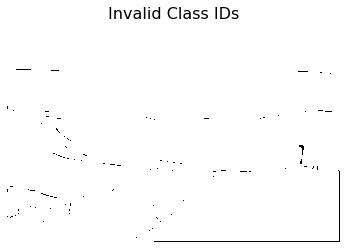

In [3]:
def get_image(instance_id, dataset_dir=ADE2016_DIR):
    ''' Get an image from an instance as a npy matrix of shape [height, width, 3] '''
    images_dir = os.path.join(dataset_dir, "images") 
    print(images_dir)
    image = cv2.imread(os.path.join(images_dir, "ADE_" + str(instance_id).zfill(8) + ".jpg"))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


def get_annotation(instance_id, dataset_dir=ADE2016_DIR):
    ''' Get an annotation from an instance as a npy matrix of shape [height, width, 3] '''
    annotations_dir = os.path.join(dataset_dir, "annotations") 
    annotation = cv2.imread(os.path.join(annotations_dir, "ADE_" + str(instance_id).zfill(8) + ".png"))
    return annotation


def get_label(instance_id, dataset_dir=ADE2016_DIR):
    ''' Get a label from an instance as a npy matrix of shape [height, width] '''
    labels_dir = os.path.join(dataset_dir, "labels") 
    label = np.load(os.path.join(labels_dir, "ADE_" + str(instance_id).zfill(8) + ".npy"))
    return label


def plot_image(instance_id, dataset_dir=ADE2016_DIR, title=None):
    ''' Plot an image instance '''
    image = get_image(instance_id, dataset_dir)
    plt.imshow(image)
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()
    
    
def plot_annotation(instance_id, dataset_dir=ADE2016_DIR, title=None):
    ''' Plot an annotation instance '''
    annotation = get_annotation(instance_id, dataset_dir)
    plt.imshow(annotation)
    plt.title(title, fontsize=16)
    plt.show()
    
    
def plot_label(instance_id, dataset_dir=ADE2016_DIR, title=None):
    ''' Plot an annotation instance '''
    label = get_label(instance_id, dataset_dir)
    plt.imshow(label, cmap='turbo', interpolation='none', vmin=0, vmax=NUM_ORIGINAL_CLASSES)
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

    
def plot_label_class_id(instance_id, class_id, dataset_dir=ADE2016_DIR, title=None):
    ''' Plot a label instance with only a specific class_id highlighted as white '''
    label = get_label(instance_id, dataset_dir)
    mask = ma.masked_where(label == class_id, label).mask
    plt.imshow(mask, cmap='binary', interpolation='none', vmin=0, vmax=1)
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()
    
    
def plot_label_class_ids(instance_id, class_ids, dataset_dir=ADE2016_DIR, title=None):
    ''' Plot a label instance with only a set of class_ids '''
    label = get_label(instance_id, dataset_dir)
    mask_found = False
    for class_id in class_ids:
        if mask_found == False:
            mask = ma.masked_where(label == class_id, label).mask
            mask_found = True
        else:
            mask = mask | ma.masked_where(label == class_id, label).mask
    if mask_found:
        plt.imshow(mask, cmap='binary', interpolation='none', vmin=0, vmax=1)
        plt.title(title, fontsize=16)
        plt.show()
        

    
instance = 3 #5148 #534 #4 #100
plot_image(instance, title="Original Image")
plot_label(instance, title="Segmentation Image")
plot_label_class_id(instance, CLASS_ID_INVALID, title="Invalid Class IDs")



## Interpolate the Labels Data

..\datasets\ADE\images


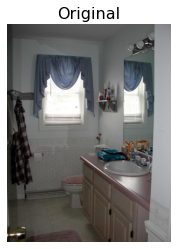

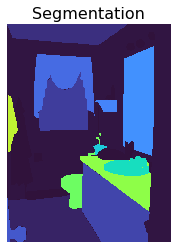

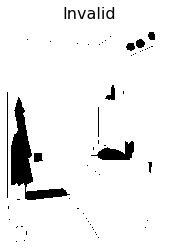

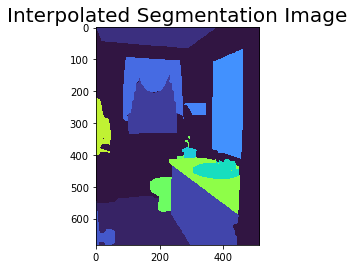

..\datasets\ADE\images


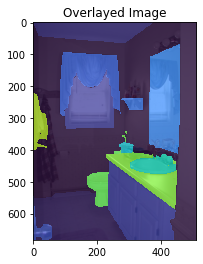

Here is a problematic example where there is too many invalid class ids to interpolate accurately
..\datasets\ADE\images


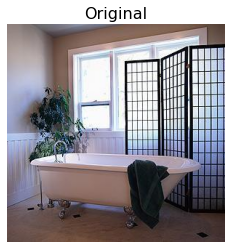

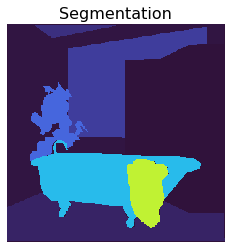

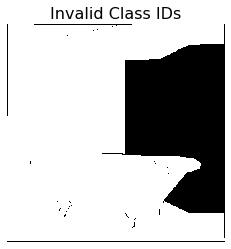

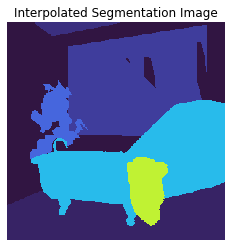

..\datasets\ADE\images


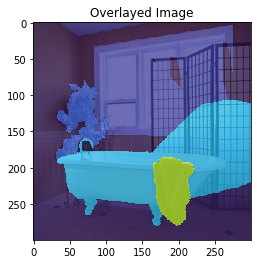

In such a case, we would cull this out of our dataset


In [5]:
# We are going to remove the invalid nodes as best we can using nearest neighbor interpolation.

def interpolate_class_id_invalid(label):
    ''' Interpolate the label to fill invalid nodes with the nearest neighbor '''
    mask = (label != CLASS_ID_INVALID)
    if np.count_nonzero(mask) == 0:
        return label # The entire label is invalid node
    xx, yy = np.meshgrid(np.arange(label.shape[1]), np.arange(label.shape[0]))
    xym = np.vstack( (np.ravel(xx[mask]), np.ravel(yy[mask])) ).T

    # Get valid class ids
    valid_class_ids = np.ravel(label[:,:][mask] )
    # Interpolate
    interp = scipy.interpolate.NearestNDInterpolator( xym, valid_class_ids )
    # Reshape to the 2D matrix
    interpolated_label = interp(np.ravel(xx), np.ravel(yy)).reshape( xx.shape )
    interpolated_label = interpolated_label.astype(np.uint16)
    
    # Assert that there are no more invalid pixels
    assert(np.count_nonzero(interpolated_label==0)==0)
    return interpolated_label


def create_labels_interpolated(dataset_dir=ADE2016_DIR):
    ''' Create labels_interpolated directory and create npy files to it '''
    # Create labels_interpolated directory
    labels_interpolated_dir = os.path.join(dataset_dir, "labels")
    assert(not os.path.isdir(labels_interpolated_dir))
    os.mkdir(labels_interpolated_dir)
    
    labels_dir = os.path.join(dataset_dir, "labels_original") 
    
    for label_file in os.listdir(labels_dir):    
        label_deconstructed = re.split('\_|\.', label_file)     
        tag = label_deconstructed[0]
        instance_id = label_deconstructed[2]
        label_interpolated_file = tag + "_" + instance_id + "." + "npy"
        
        label = np.load(os.path.join(labels_dir, label_file))
        label_interpolated = interpolate_class_id_invalid(label)
        
        np.save(os.path.join(labels_interpolated_dir, label_interpolated_file), label_interpolated)
        #Time elapsed: 6746.8434834480286


def demonstrate_interpolation():
    #instance = 1
    instance = 109

    plot_image(instance, title="Original")
    plot_label(instance, title="Segmentation")
    plot_label_class_id(instance, CLASS_ID_INVALID, title="Invalid")

    label = get_label(instance)
    interpolated_label = interpolate_class_id_invalid(label)
    plt.imshow(interpolated_label, cmap='turbo', interpolation='none', vmin=0, vmax=NUM_ORIGINAL_CLASSES)
    plt.title("Interpolated Segmentation Image", fontsize=20)
    plt.show()

    image = get_image(instance)
    plt.imshow(image)
    plt.imshow(interpolated_label, cmap='turbo', alpha=0.75, interpolation='none', vmin=0, vmax=NUM_ORIGINAL_CLASSES)
    plt.title("Overlayed Image")
    plt.show()
    
    
    print("Here is a problematic example where there is too many invalid class ids to interpolate accurately")
    instance = 98 
    plot_image(instance, title="Original")
    plt.axis('off')
    plot_label(instance, title="Segmentation")
    plot_label_class_id(instance, CLASS_ID_INVALID, title="Invalid Class IDs")

    label = get_label(instance)
    interpolated_label = interpolate_class_id_invalid(label)
    plt.imshow(interpolated_label, cmap='turbo', interpolation='none', vmin=0, vmax=NUM_ORIGINAL_CLASSES)
    plt.title("Interpolated Segmentation Image")
    plt.axis('off')
    plt.show()

    image = get_image(instance)
    plt.imshow(image)
    plt.imshow(interpolated_label, cmap='turbo', alpha=0.75, interpolation='none', vmin=0, vmax=NUM_ORIGINAL_CLASSES)
    plt.title("Overlayed Image")
    plt.show()

    print("In such a case, we would cull this out of our dataset")


'''
start = time.time()
create_labels_interpolated()
end = time.time()
print("Time elapsed: {}".format(end-start))
'''

demonstrate_interpolation()


## Create Dataframes

In [15]:
CLASS_ID_INVALID = 0
NUM_ORIGINAL_CLASSES = 150


def build_class_info_df(dataset_dir):
    misc_dir = os.path.join(dataset_dir, "miscellaneous") 
    class_info_path = os.path.join(misc_dir, "objectInfo150.txt")
    return pd.read_csv(class_info_path, header=0, sep='\t', lineterminator='\n')

class_info_df = build_class_info_df(dataset_dir=ADE2016_DIR)

# CLASSES
CLASSES = np.asarray(class_info_df['Name'])
for i in range(len(CLASSES)):
    CLASSES[i] = re.split(',', CLASSES[i])[0]
    CLASSES[i] = CLASSES[i].rstrip()
NUM_ORIGINAL_CLASSES = CLASSES.size



def get_num_instances(dataset_dir=ADE2016_DIR):
    # Return the number of instances in the dataset
    annotations_dir = os.path.join(dataset_dir, "annotations")     
    images_dir = os.path.join(dataset_dir, "images")
    labels_dir = os.path.join(dataset_dir, "labels")     

    
    annotation_count = 0
    for annotation in os.listdir(annotations_dir):
        annotation_count += 1
    
    image_count = 0
    for image in os.listdir(images_dir):
        image_count += 1
        
    label_count = 0
    for label in os.listdir(labels_dir):
        label_count += 1
    
    # Assert that the number of annotations equals the number of images equals the number of labels
    assert(annotation_count == image_count)
    assert(image_count == label_count)

    return annotation_count



def save_dataframe(df, name, dataset_dir=ADE2016_DIR, index=False):
    dataframes_dir = os.path.join(dataset_dir, "dataframes")     
    if not os.path.isdir(dataframes_dir):
        os.mkdir(dataframes_dir)

    df.to_csv(os.path.join(dataframes_dir, name), index=index)

    
def load_dataframe(filename, dataset_dir=ADE2016_DIR, header=None, sep=',', index_col=0):
    dataframes_dir = os.path.join(dataset_dir, "dataframes")     
    return pd.read_csv(os.path.join(dataframes_dir, filename), header=header, sep=sep, index_col=index_col, lineterminator='\n')




def build_initial_ADE_df(dataset_dir=ADE2016_DIR):
    ''' The initial ADE has features: id, width, height, scene, and invalid ratio'''
    labels_dir = os.path.join(dataset_dir, "labels")     
    
    total_num_instances = get_num_instances(dataset_dir)
    
    id_col = np.zeros(total_num_instances, dtype=np.int64)   
    width_col = np.zeros(total_num_instances, dtype=np.int64)   
    height_col = np.zeros(total_num_instances, dtype=np.int64)
    invalid_class_node_ratio_col = np.zeros(total_num_instances, dtype=np.float64)   

    for label_file in os.listdir(labels_dir):
        label = np.load(os.path.join(labels_dir, label_file))
        
        instance_id = int(re.split('\_|\.', label_file)[2])
        width = label.shape[1]
        height = label.shape[0]

        id_col[instance_id] = instance_id
        width_col[instance_id] = width
        height_col[instance_id] = height
        invalid_class_node_ratio_col[instance_id] = ((label == CLASS_ID_INVALID).sum())/(width*height)
        
    # Create scene column using the text file given
    misc_dir = os.path.join(dataset_dir, "miscellaneous") 
    scene_categories_path = os.path.join(misc_dir, "sceneCategories.txt")
    scene_col = (pd.read_csv(scene_categories_path, header=None, sep=' ', lineterminator='\n').iloc[:,1]).to_numpy() 
    assert(scene_col.shape[0] == total_num_instances)
    
    df = pd.DataFrame({
        "id" : id_col,
        "width" : width_col,
        "height" : height_col,
        "scene" : scene_col,
        "invalid" : invalid_class_node_ratio_col,           
        })
    
    return df


'''
start = time.time()
initial_ADE_df = build_initial_ADE_df()
save_dataframe(initial_ADE_df, "initial_ADE.csv")
end = time.time()
print("Time elapsed: {}".format(end-start)) #Time elapsed: 238.38744187355042
print(initial_ADE_df.head())
'''



def create_class_proportion_df(dataset_dir=ADE2016_DIR):
    ''' Create pixel-ratio of each class to measure its apparency in an image. We can use pearson correlation to see which classes can be binned together '''
    labels_interpolated_dir = os.path.join(dataset_dir, "labels_interpolated")

    total_num_instances = get_num_instances(dataset_dir)
    class_proportion = np.arange(1, NUM_ORIGINAL_CLASSES+1, 1, dtype=np.float64)   
    class_proportion = np.tile(class_proportion,(total_num_instances,1))
    
    def proportion(class_id, label):
        return ((label == class_id).sum())/label.size
    
    # https://stackoverflow.com/questions/4495882/numpy-vectorize-using-lists-as-arguments
    # Use vectorization for speed-up
    def curry_proportion(label):
        def proportion_curried(class_id):
            return proportion(class_id, label)  
        return proportion_curried

    for label_file in os.listdir(labels_interpolated_dir):
        label_deconstructed = re.split('\_|\.', label_file)     
        instance_id = int(label_deconstructed[3])
                
        label = np.load(os.path.join(labels_interpolated_dir, label_file)).flatten()
        vector_proportion = np.vectorize(curry_proportion(label))
        class_proportion[instance_id] = vector_proportion(class_proportion[instance_id])


    df = pd.DataFrame(class_proportion, columns=CLASSES)
    # Time elapsed: 1445.3204731941223
    return df
    
    
'''
start = time.time()
class_proportion_df = create_class_proportion_df(dataset_dir=ADE2016_DIR)
save_dataframe(class_proportion_df, "class_proportion.csv", index=True)
print(class_proportion_df.head())
end = time.time()
print("Time elapsed: {}".format(end-start))
'''



def create_master_df(dataset_dir=ADE2016_DIR):
    ''' Merge all the dataframes by column '''
    intial_df = load_dataframe("initial_ADE.csv", header=0)
    class_proportion_df = load_dataframe("class_proportion.csv", header=0)
    assert(intial_df.shape[0] == class_proportion_df.shape[0])
    master_df = pd.concat([intial_df, class_proportion_df], axis=1)
    
    # Track the id of the instance
    master_df.reset_index(inplace=True)
    
    # Remove carriage return from the column names
    master_df_cols = master_df.columns.values
    for i in range(len(master_df_cols)):
        master_df_cols[i] = master_df_cols[i].rstrip()
    master_df.columns = master_df_cols

    return master_df


'''
start = time.time()
ADE_df = create_master_df(dataset_dir=ADE2016_DIR)
save_dataframe(ADE_df, "ADE.csv", index=True)
print(ADE_df.head()) 
end = time.time()
print("Time elapsed: {}".format(end-start)) # Time elapsed: 1.9375097751617432
'''


ADE_df = load_dataframe("ADE_master.csv", header=0)
print(ADE_df.head())


       id dataset  width  height             scene   invalid      wall  \
index                                                                    
0       0     ADE    683     512  airport_terminal  0.098448  0.175218   
1       1     ADE    711     512  airport_terminal  0.036494  0.190530   
2       2     ADE    683     512       art_gallery  0.200949  0.287724   
3       3     ADE    384     251          badlands  0.006111  0.000000   
4       4     ADE    683     512          ball_pit  0.733860  0.000000   

       building       sky     floor  ...  pier  crt screen  plate   monitor  \
index                                ...                                      
0           0.0  0.000000  0.116633  ...   0.0         0.0    0.0  0.000000   
1           0.0  0.000000  0.344228  ...   0.0         0.0    0.0  0.000456   
2           0.0  0.000000  0.317988  ...   0.0         0.0    0.0  0.000000   
3           0.0  0.214351  0.000000  ...   0.0         0.0    0.0  0.000000   
4      

## Data Cleaning

index
0          (0.068, 0.13]
1          (0.027, 0.04]
2           (0.13, 0.27]
3        (-0.01, 0.0092]
4            (0.27, 1.0]
              ...       
22205    (-0.01, 0.0092]
22206      (0.02, 0.027]
22207    (0.0092, 0.012]
22208        (0.27, 1.0]
22209        (0.27, 1.0]
Name: invalid, Length: 22210, dtype: category
Categories (10, interval[float64, right]): [(-0.01, 0.0092] < (0.0092, 0.012] < (0.012, 0.016] < (0.016, 0.02] ... (0.04, 0.068] < (0.068, 0.13] < (0.13, 0.27] < (0.27, 1.0]]
Threshold invalid: 0.12575425803915188
Number of instances after culling: 8602
..\datasets\ADE\images


C:\Users\Victor\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Victor\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


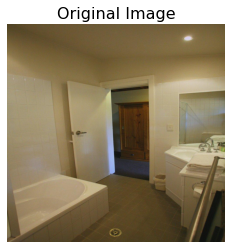

..\datasets\ADE\images


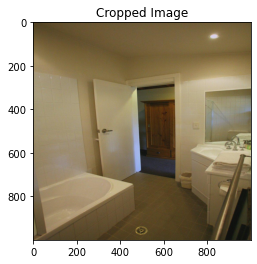

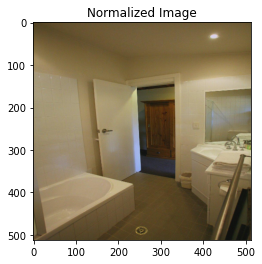

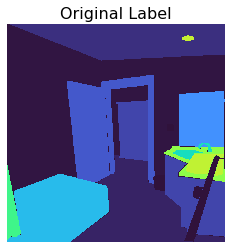

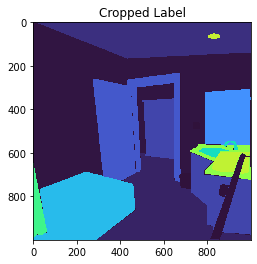

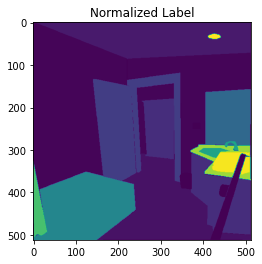

..\datasets\ADE\images


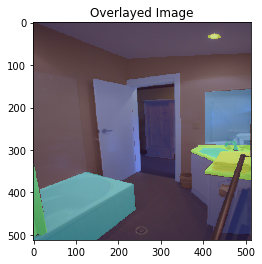

In [16]:
''' Interpolate the mask to deal with invalid labels '''
# Done in the previous "Interpolate the Labels Data" section


''' Remove Erroneous Data based on frequency binning '''
# Erroneous data 1: images with large amount of invalid labels
# Here we will cull 2/10 (20%) of the data with the most invalid nodes
qt, bins = pd.qcut(ADE_df['invalid'], q=10, precision=0, retbins=True)
print(qt)
threshold_invalid_ratio = bins[8]
print("Threshold invalid: {}".format(threshold_invalid_ratio))
ADE_df_cleaned = ADE_df[ADE_df['invalid'] <= threshold_invalid_ratio]

# Erroneous data 2: images that are too small. 
# We will not be upscaling images because our camera is expected to have a higher resolution than 513x513 to downscale to
TARGET_WIDTH = 512
TARGET_HEIGHT = 512
ADE_df_cleaned = ADE_df_cleaned[ADE_df['width'] >= TARGET_WIDTH]
ADE_df_cleaned = ADE_df_cleaned[ADE_df['height'] >= TARGET_HEIGHT]
print("Number of instances after culling: {}".format(ADE_df_cleaned.shape[0]))
#print(ADE_df_cleaned[100:150])

# Erroneous data 3: only one instance of a scene. We need at least 2 for stratified sampling
scene_counts = ADE_df_cleaned['scene'].value_counts(dropna=False)
mask = (scene_counts == 1)
single_scenes = scene_counts[mask].index
ADE_df_cleaned['scene'] = ADE_df_cleaned['scene'] .map(lambda x : x if x not in single_scenes else 'misc')



''' Normalizing the size of our images and respective mask to 512x512 '''
def crop_bottom_center(image):
    ''' Crop the image to a square by the bottom center '''
    y,x = image.shape[0], image.shape[1]
    new_size = min(x, y)
    start_x = x//2-(new_size//2)
    start_y = y-new_size
    return image[start_y:start_y+new_size, start_x:start_x+new_size]

def bilinear_interpolation(image, target_width=TARGET_WIDTH, target_height=TARGET_HEIGHT):
    ''' Use bilinear interpolation to resize the image to the target dimension '''
    
    pass


def normalize_image_and_label(instance, target_width=TARGET_WIDTH, target_height=TARGET_HEIGHT):
    ''' We will use Bilinear Interpolation to resize the original image to the target dimension.
        We will use Nearest Neighbor Interpolation to resize the label image to the target dimension.
        This is to not introduce different class id labels to the label image. '''
    image = get_image(instance)
    cropped_image = crop_bottom_center(image)
    normalized_image = cv2.resize(cropped_image, dsize=(TARGET_WIDTH, TARGET_HEIGHT), interpolation=cv2.INTER_LINEAR)
    
    label = get_label_interpolated(instance)
    cropped_label = crop_bottom_center(label)
    normalized_label = cv2.resize(cropped_label, dsize=(TARGET_WIDTH, TARGET_HEIGHT), interpolation=cv2.INTER_NEAREST)        
    return normalized_image, normalized_label
        
        
    
def preprocess_images_and_labels(df, dataset_dir=ADE2016_DIR):
    ''' Create two directories: images_preprocessed and labels_preprocessed that has the culled, cropped, and resized versions of its predecessor '''
    images_preprocessed_dir = os.path.join(dataset_dir, "images_preprocessed")
    labels_preprocessed_dir = os.path.join(dataset_dir, "labels_preprocessed")
    assert(not os.path.isdir(images_preprocessed_dir))
    assert(not os.path.isdir(labels_preprocessed_dir))
    os.mkdir(images_preprocessed_dir) 
    os.mkdir(labels_preprocessed_dir) 
    
    labels_interpolated_dir = os.path.join(dataset_dir, "labels_interpolated") 
    instance_ids = df['index'].to_numpy()
    for instance_id in instance_ids:
        image_normalized, label_normalized = normalize_image_and_label(instance_id)
        
        image_preprocessed_file = "ADE" + "_" + str(instance_id).zfill(8) + ".jpg" 
        image_preprocessed_file_path = os.path.join(images_preprocessed_dir, image_preprocessed_file)
        image_normalized_jpg = Image.fromarray(image_normalized.astype('uint8')).convert('RGB')
        image_normalized_jpg.save(image_preprocessed_file_path)
        
        label_preprocessed_file = "ADE" + "_" + str(instance_id).zfill(8) + ".npy" 
        label_preprocessed_file_path = os.path.join(labels_preprocessed_dir, label_preprocessed_file)
        np.save(label_preprocessed_file_path, label_normalized)


def demonstrate_crop():
    instance = 136 #5 #136
    # Plot original image
    plot_image(instance, title="Original Image")
    
    # Plot cropped image
    image = get_image(instance)
    cropped_image = crop_bottom_center(image)
    plt.imshow(cropped_image)
    plt.title("Cropped Image")
    plt.show()
    
    # Plot normalized image
    normalized_image = cv2.resize(cropped_image, dsize=(TARGET_WIDTH, TARGET_HEIGHT), interpolation=cv2.INTER_LINEAR)
    plt.imshow(normalized_image)
    plt.title("Normalized Image")
    plt.show()
    
    
    # Plot original segmentation
    plot_label(instance, title="Original Label")
    
    # Plot croppede segmentation
    label = get_label_interpolated(instance)
    cropped_label = crop_bottom_center(label)
    plt.imshow(cropped_label, cmap='turbo', interpolation='none', vmin=0, vmax=NUM_ORIGINAL_CLASSES)
    plt.title("Cropped Label")
    plt.show()
    
    # Plot normalized label
    normalized_label = cv2.resize(cropped_label, dsize=(TARGET_WIDTH, TARGET_HEIGHT), interpolation=cv2.INTER_NEAREST)
    plt.imshow(normalized_label)
    plt.title("Normalized Label")
    plt.show()
    

    # Plot overlay
    norm_image, norm_label = normalize_image_and_label(instance)
    plt.imshow(norm_image)
    plt.imshow(norm_label, cmap='turbo', alpha=0.5, interpolation='none', vmin=0, vmax=NUM_ORIGINAL_CLASSES)
    plt.title("Overlayed Image")
    plt.show()
    
'''
preprocess_images_and_labels(df=ADE_df_cleaned)
'''

demonstrate_crop()




## Data Visualization

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7311 entries, 17653 to 15033
Columns: 155 entries, index to flag
dtypes: float64(151), int64(3), object(1)
memory usage: 8.7+ MB
None
       index  width  height        scene   invalid      wall  building  \
17653  17653    683     512       street  0.034398  0.000000  0.130545   
17524  17524    683     512       street  0.010077  0.000000  0.603327   
7176    7176    683     512  dining_room  0.020043  0.321568  0.000000   
10664  10664    589     512      kitchen  0.035922  0.394322  0.000000   
17760  17760    683     512       street  0.017838  0.022297  0.509605   

            sky     floor      tree  ...  pier  crt screen  plate  monitor  \
17653  0.177005  0.000000  0.252085  ...   0.0         0.0    0.0      0.0   
17524  0.022051  0.000000  0.000000  ...   0.0         0.0    0.0      0.0   
7176   0.000000  0.123550  0.000000  ...   0.0         0.0    0.0      0.0   
10664  0.000000  0.024674  0.000000  ...   0.0         0.0 

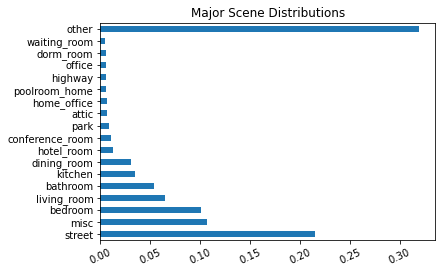

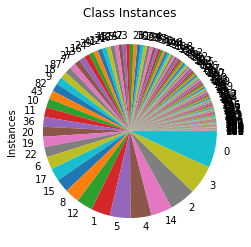

['wall', 'floor', 'sky', 'door', 'tree', 'ceiling', 'building', 'person', 'windowpane', 'table', 'plant', 'road', 'painting', 'chair', 'car', 'lamp', 'sidewalk', 'cabinet', 'signboard', 'light', 'grass', 'curtain', 'streetlight', 'bed', 'mirror', 'earth', 'mountain', 'shelf', 'cushion', 'box', 'fence', 'seat', 'flower', 'vase', 'pot', 'sink', 'sofa', 'rug', 'armchair', 'book', 'sconce', 'pole', 'bottle', 'pillow', 'stairs', 'railing', 'column', 'clock', 'coffee table', 'rock', 'water', 'ashcan', 'desk', 'house', 'bench', 'sea', 'basket', 'television receiver', 'chandelier', 'plate', 'path', 'stairway', 'van', 'bag', 'chest of drawers', 'awning', 'traffic light', 'stove', 'glass', 'towel', 'field', 'stool', 'tray', 'fireplace', 'bannister', 'trade name', 'oven', 'truck', 'flag', 'base', 'refrigerator', 'toilet', 'fan', 'bathtub', 'wardrobe', 'palm', 'counter', 'blind', 'poster', 'bicycle', 'plaything', 'countertop', 'microwave', 'swivel chair', 'river', 'sand', 'ottoman', 'boat', 'canop

In [20]:
# Header information
print(train_df.info())
print(train_df.head())
print()

# Pearson correlation
#print(train_df.iloc[:,5:].corr())
#print(train_df['sign'].corr(train_df['base']))

correlation_df = train_df.iloc[:,5:].corr() #.abs()

for j in range(150):
    a = correlation_df.iloc[j]
    class_names = list(a.index)
    corr_coeffs = list(a)

    correlation = []
    for i in range(len(list(a))):
        correlation.append(tuple((corr_coeffs[i], class_names[i])))

    print("\"{}\"".format(a.name))
    print(sorted(correlation, reverse=True)[1:5])



# Plot the major scene distribution
scene_count = train_df['scene'].value_counts(dropna=False, normalize=True)
threshold = 0.005
mask = scene_count > threshold
other_scene = scene_count.loc[~mask].sum()
scene_count = scene_count.loc[mask]
scene_count['other'] = other_scene
scene_count.plot(kind='barh')
plt.xticks(rotation=25)
plt.title("Major Scene Distributions")
plt.show()
print()



# Plot Pie Chart of Class distrubtion
class_info_df['Instances'] = class_info_df['Train'] + class_info_df['Val']
class_info_df.sort_values('Instances', ascending=True)['Instances'].plot(kind='pie',use_index=False)
plt.title("Class Instances")
plt.show()
print(class_info_df.sort_values(by=['Instances'], ascending=False)['Name'].to_list())
print()


